In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda, multiply, concatenate, add
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras import optimizers
from keras import regularizers
from keras.datasets import mnist
import pandas as pd
import tensorflow as tf

/Users/semihakbayrak/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using TensorFlow backend.


In [2]:
# Initialize Keras with Tensorflow session
sess = tf.Session()
K.set_session(sess)

In [3]:
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('u5.base', sep='\t', header=None, names=rnames)

In [4]:
M = 1682
N = 943

R = np.nan*np.ones((M,N))

for k in range(len(ratings)):
    i = ratings['movie_id'][k] - 1
    j = ratings['user_id'][k] - 1
    r = ratings['rating'][k]
    R[i,j] = r

In [5]:
batch_size = None
movie_in_dim = N
user_in_dim = M
latent_dim = 40
intermediate_dim = 120
semi_final_dim = 80
final_dim = 1
nb_epoch = 5
epsilon_std = 1.0

In [6]:
#encoder
x_m = Input(batch_shape=(batch_size, movie_in_dim))
x_u = Input(batch_shape=(batch_size, user_in_dim))
h_m = Dense(latent_dim, activation='relu', use_bias=True, kernel_initializer='random_uniform', bias_initializer='zeros')(x_m)
h_u = Dense(latent_dim, activation='relu', use_bias=True, kernel_initializer='random_uniform', bias_initializer='zeros')(x_u)
z_m = Dense(latent_dim, activation='linear', use_bias=True, kernel_initializer='random_uniform', bias_initializer='zeros')(h_m)
z_u = Dense(latent_dim, activation='linear', use_bias=True, kernel_initializer='random_uniform', bias_initializer='zeros')(h_u)

In [7]:
#decoder
def inner_mult(args):
    z_m,z_u = args
    return tf.multiply(z_m,z_u)
    
z = Lambda(inner_mult,output_shape=(latent_dim,))([z_m, z_u])
print z

decoder_h1 = Dense(semi_final_dim, activation='relu', use_bias=True, kernel_initializer='random_uniform', bias_initializer='zeros')
decoder_h2 = Dense(semi_final_dim, activation='relu', use_bias=True, kernel_initializer='random_uniform', bias_initializer='zeros')
decoder_h3 = Dense(semi_final_dim/2, activation='relu', use_bias=True, kernel_initializer='random_uniform', bias_initializer='zeros')
decoder_mean = Dense(final_dim, use_bias=True, kernel_initializer='random_uniform', bias_initializer='zeros')
h_decoded1 = decoder_h1(z)
h_decoded2 = decoder_h2(h_decoded1)
h_decoded3 = decoder_h3(h_decoded2)
x_decoded_mean = decoder_mean(h_decoded3)
print x_decoded_mean

Tensor("lambda_1/Mul:0", shape=(?, 40), dtype=float32)
Tensor("dense_8/BiasAdd:0", shape=(?, 1), dtype=float32)


In [8]:
model = Model([x_m,x_u], x_decoded_mean)
model.compile(optimizer='rmsprop', loss='mean_squared_error', lr=0.05)

In [9]:
X = np.zeros((M,N)) 

for k in range(len(ratings)):
    i = ratings['movie_id'][k] - 1
    j = ratings['user_id'][k] - 1
    r = ratings['rating'][k]
    X[i,j] = r

In [10]:
X_m = np.zeros((len(ratings),N)) 
X_u = np.zeros((len(ratings),M)) 
y = np.zeros((len(ratings),1))

for k in range(len(ratings)):
    i = ratings['movie_id'][k] - 1
    j = ratings['user_id'][k] - 1
    r = ratings['rating'][k]
    X_m[k] = X[i,:]
    X_u[k] = X[:,j]
    y[k] = r
    X_m[k,j] = 0
    X_u[k,i] = 0

In [11]:
model.fit([X_m,X_u], y,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=50,
        validation_data=None,verbose=2)

/Users/semihakbayrak/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
/Users/semihakbayrak/anaconda/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:2124: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/5
12s - loss: 1.4896
Epoch 2/5
9s - loss: 0.9277
Epoch 3/5
9s - loss: 0.8676
Epoch 4/5
9s - loss: 0.8389
Epoch 5/5
9s - loss: 0.8191


In [12]:
X_m_test = np.zeros((M,N)) #datamatrix
X_u_test = np.zeros((N,M)) #datamatrix

for i in range(M):
    X_m_test[i] = X[i,:]

for i in range(N):
    X_u_test[i] = X[:,i]

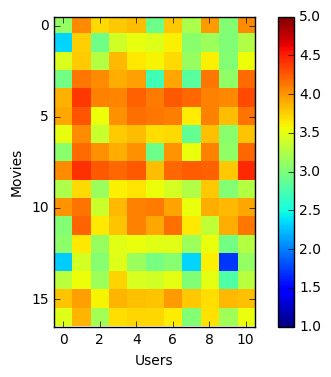

In [13]:
encoder_u = Model(x_u, z_u)
encoder_m = Model(x_m, z_m)

x_test_encoded_u = encoder_u.predict(X_u_test, batch_size=N)
x_test_encoded_m = encoder_m.predict(X_m_test, batch_size=M)
decoder_input = Input(shape=(latent_dim,))
_h_decoded1 = decoder_h1(decoder_input)
_h_decoded2 = decoder_h2(_h_decoded1)
_h_decoded3 = decoder_h3(_h_decoded2)
_x_decoded_mean = decoder_mean(_h_decoded3)
generator = Model(decoder_input, _x_decoded_mean)

Data_show = R[3:20,5:16]

for i in range(17):
    for j in range(11):
        x_decoded = np.multiply(x_test_encoded_m[i+3],x_test_encoded_u[j+5])
        x_decoded = x_decoded.reshape(1,latent_dim)
        Data_show[i,j] = generator.predict(x_decoded)

plt.imshow(R[3:20,5:16], interpolation='nearest',vmax=5,vmin=1)
plt.colorbar()
plt.set_cmap('jet')
plt.xlabel('Users')
plt.ylabel('Movies')
plt.show()

In [14]:
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings_test = pd.read_table('u5.test', sep='\t', header=None, names=rnames)

In [15]:
count = 0
accurate = 0
rmse = 0
mae = 0
for k in range(len(ratings_test)):
    i = ratings_test['movie_id'][k] - 1
    j = ratings_test['user_id'][k] - 1
    r = ratings_test['rating'][k]
    #print "real: " + str(r)
    x_d = np.multiply(x_test_encoded_m[i],x_test_encoded_u[j])
    x_d = x_d.reshape(1,latent_dim)
    pred = generator.predict(x_d)[0][0]
    rmse = rmse + (pred-r)**2
    mae = mae + np.absolute(pred-r)
    pred_rounded = int(round(pred))
    count = count + 1
    if pred_rounded == r:
        accurate = accurate + 1
    #print pred_rounded
accuracy = 1.0*accurate/count
print accuracy
rmse = np.sqrt(rmse/count)
print rmse
mae = mae/count
print mae

0.40035
0.923333222086
0.739427017653
